<h2 style="text-align:center; color: orange">⌞Visualisations⌝</h2>

This notebook visualizes key insights from the dataset (EDA) and evaluates the best performing model.

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import learning_curve

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

<h4 style="text-decoration:underline">1. Data Loading & Cleaning</h4>

In [64]:
# Load raw data for EDA
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Convert TotalCharges -> Numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(subset=['TotalCharges'], inplace=True)
df['ChurnBinary'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

print(f"Data Loaded: {df.shape}")

Data Loaded: (7032, 22)


<h4 style="text-decoration:underline">2. Target Distribution</h4>
Visualizing the class imbalance.

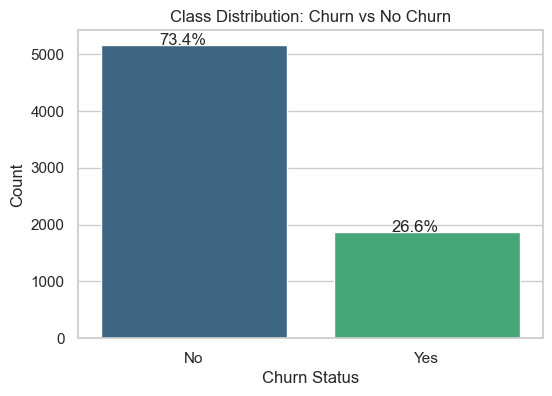

In [65]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='Churn', data=df, hue="Churn", palette='viridis')
plt.title('Class Distribution: Churn vs No Churn')
plt.xlabel('Churn Status')
plt.ylabel('Count')

# Add percentages
total = len(df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center')
plt.show()

<h4 style="text-decoration:underline">3. Numerical Feature Analysis</h4>
Examining distributions of Tenure and Charges.

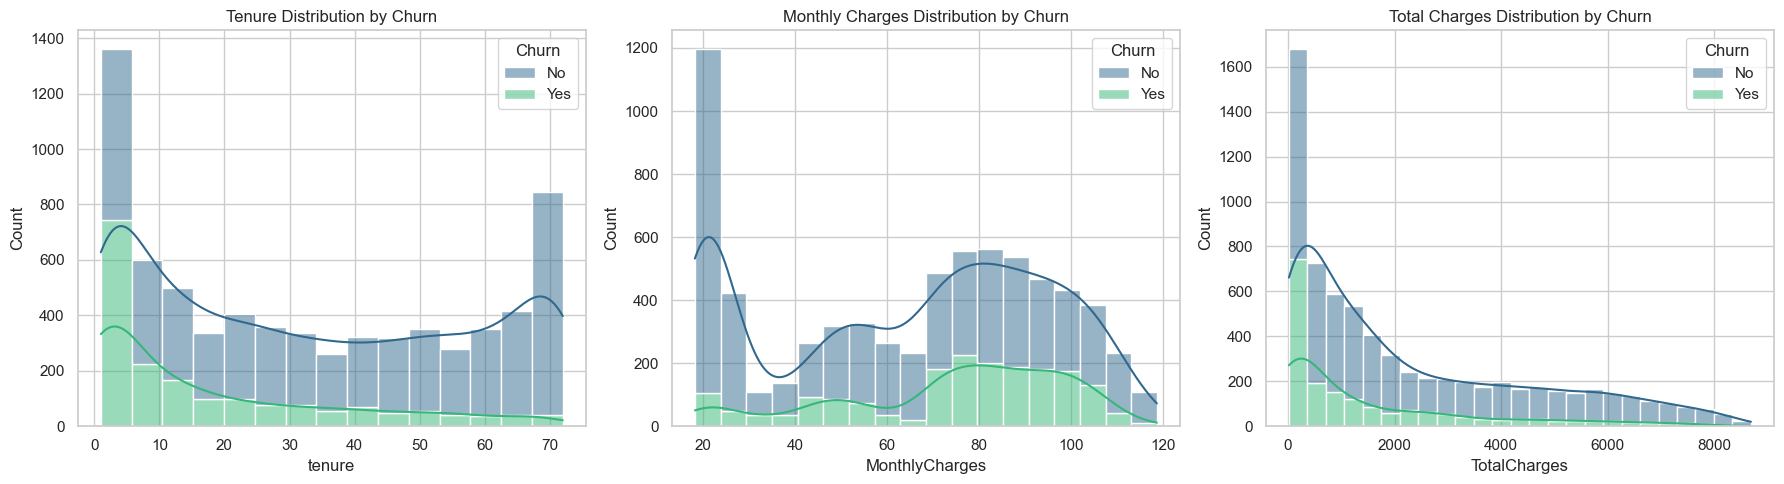

In [66]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(data=df, x='tenure', hue='Churn', multiple='stack', kde=True, ax=axes[0], palette='viridis')
axes[0].set_title('Tenure Distribution by Churn')

sns.histplot(data=df, x='MonthlyCharges', hue='Churn', multiple='stack', kde=True, ax=axes[1], palette='viridis')
axes[1].set_title('Monthly Charges Distribution by Churn')

sns.histplot(data=df, x='TotalCharges', hue='Churn', multiple='stack', kde=True, ax=axes[2], palette='viridis')
axes[2].set_title('Total Charges Distribution by Churn')

plt.tight_layout()
plt.show()

<h4 style="text-decoration:underline">4. Key Categorical Drivers</h4>
Contract Type, Payment Method, and Internet Service impact on Churn.

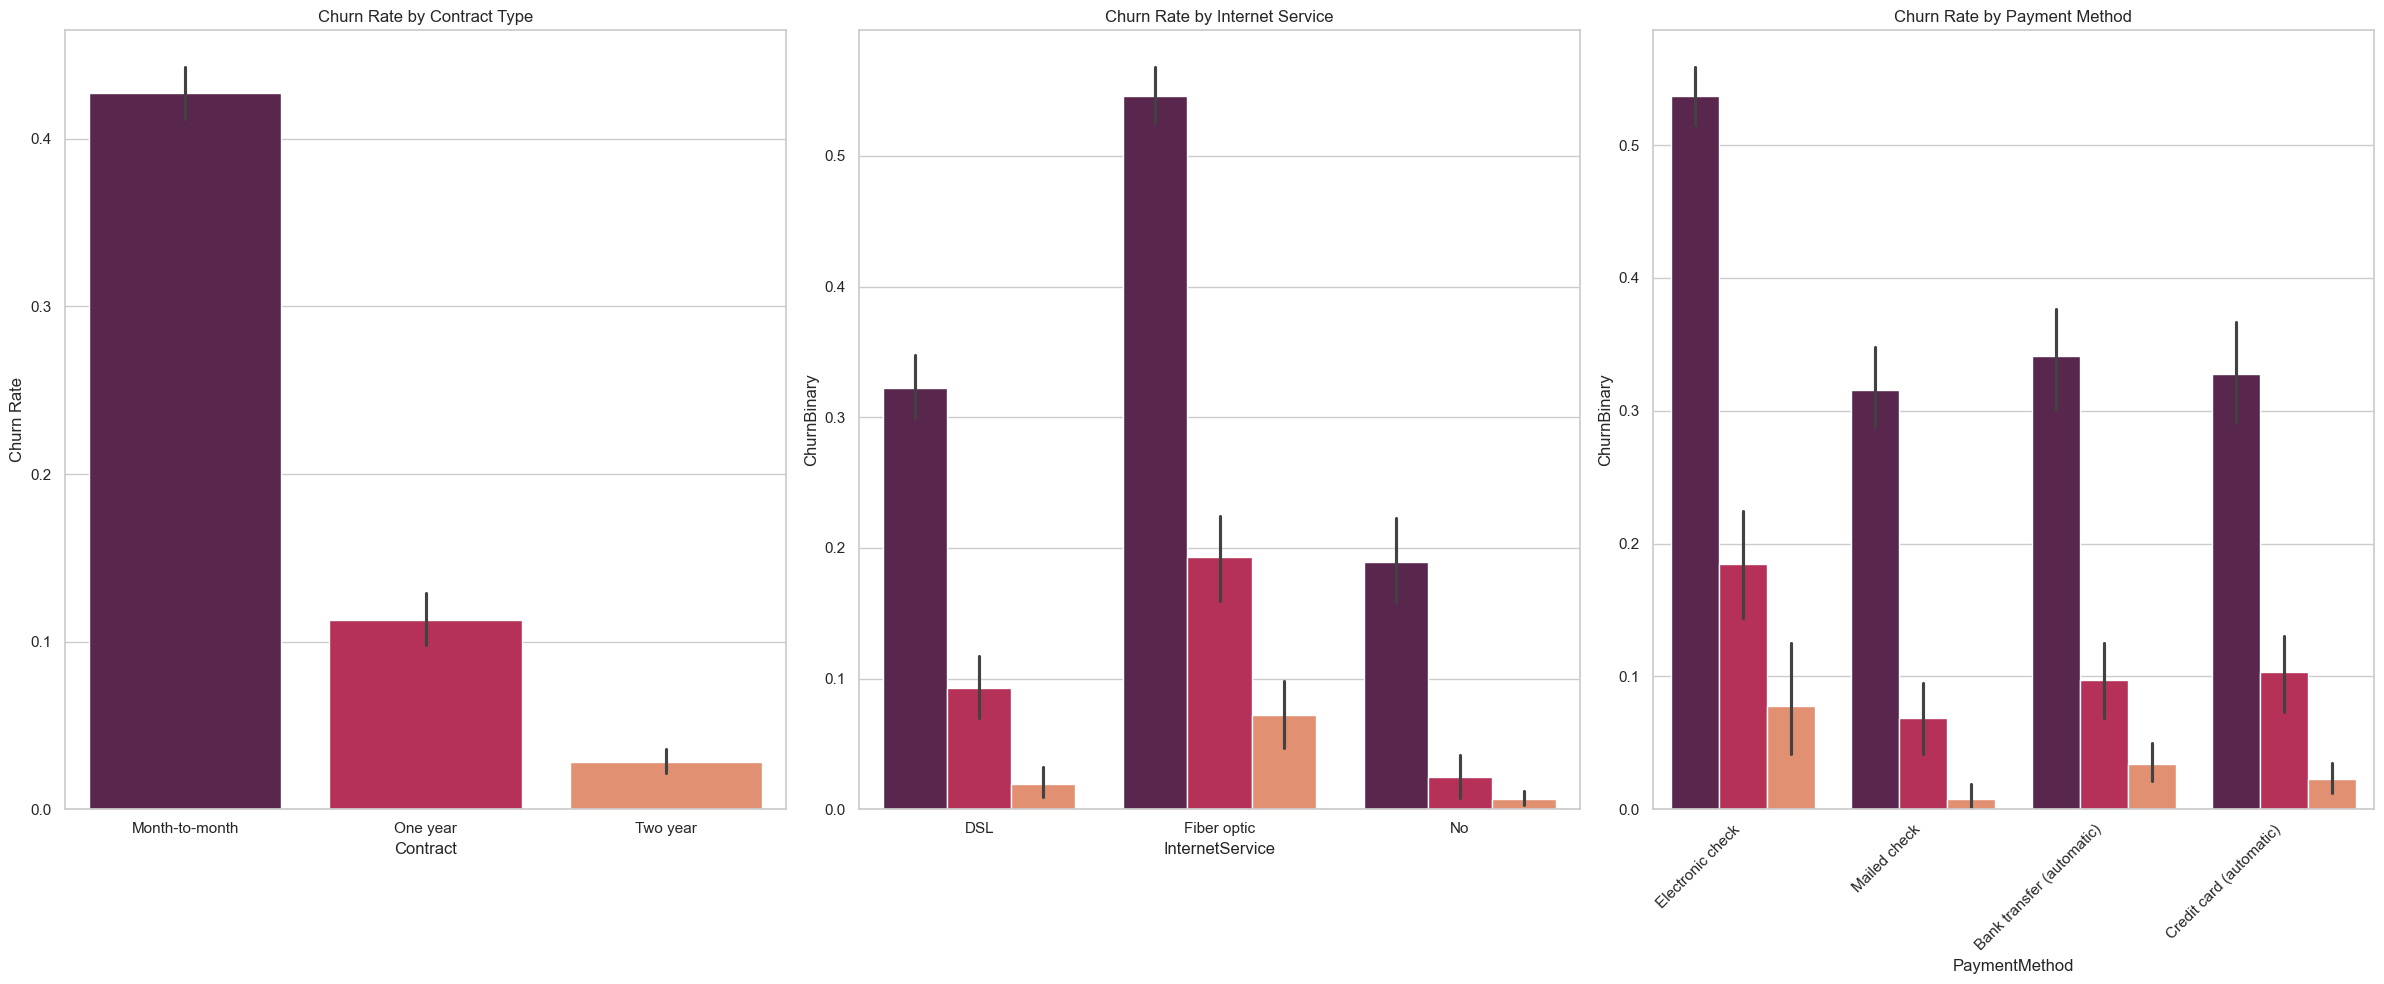

In [67]:
fig, axes = plt.subplots(1, 3, figsize=(24, 10))

# Contract
sns.barplot(x='Contract', y='ChurnBinary', data=df, ax=axes[0], palette='rocket', hue='Contract', legend=False)
axes[0].set_title('Churn Rate by Contract Type')
axes[0].set_ylabel('Churn Rate')

# InternetService
sns.barplot(x='InternetService', y='ChurnBinary', data=df, ax=axes[1], palette='rocket', hue='Contract', legend=False)
axes[1].set_title('Churn Rate by Internet Service')

# PaymentMethod
sns.barplot(x='PaymentMethod', y='ChurnBinary', data=df, ax=axes[2], palette='rocket', hue='Contract', legend=False)
axes[2].set_title('Churn Rate by Payment Method')
axes[2].set_xticks(axes[2].get_xticks())
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

<h4 style="text-decoration:underline">5. Correlation Matrix</h4>

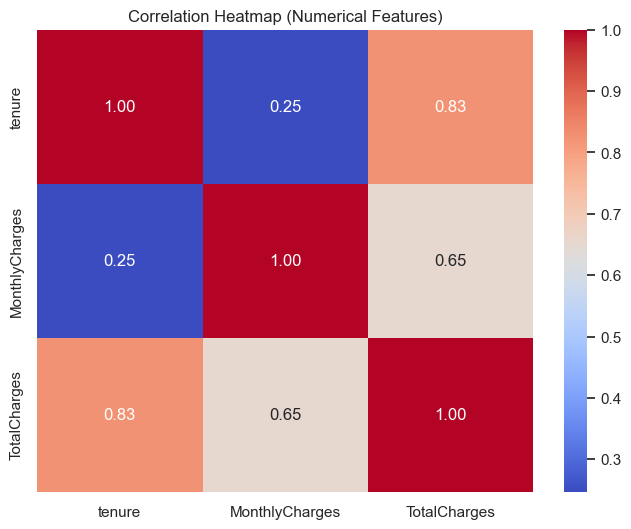

In [68]:
plt.figure(figsize=(8, 6))
corr = df[['tenure', 'MonthlyCharges', 'TotalCharges']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap (Numerical Features)')
plt.show()

<h4 style="text-decoration:underline">6. Model Evaluation</h4>
Loading the trained model and evaluating its performance.

In [69]:
# Load Processed Data and Model
try:
    X_train_processed = pd.read_csv('train_processed.csv')
    y_train_processed = X_train_processed.pop('Churn')
    
    X_test_processed = pd.read_csv('test_processed.csv')
    y_test_processed = X_test_processed.pop('Churn')
    
    model = joblib.load('models/best_model.pkl')
    print("Model and processed data loaded successfully.")
    
except FileNotFoundError:
    print("Error: Ensure preprocessing and training scripts have been run.")

Model and processed data loaded successfully.


<h4 style="text-decoration:underline">6.1. ROC-AUC Curve</h4>

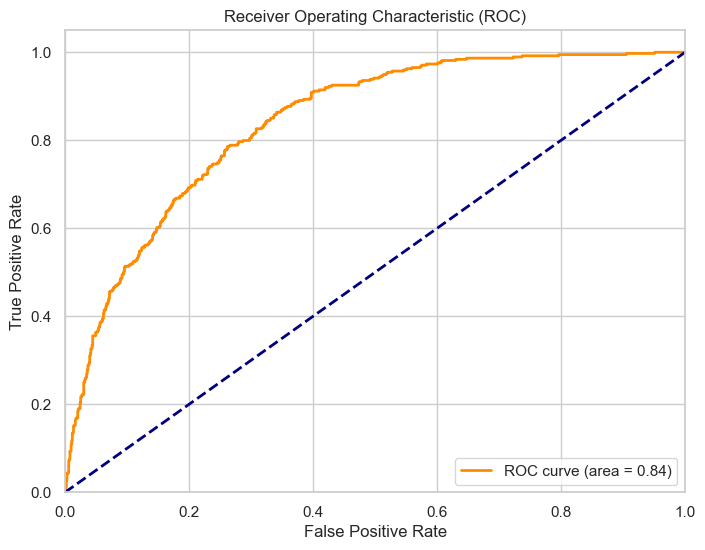

In [70]:
# Predict Probabilities
if hasattr(model, "predict_proba"):
    y_prob = model.predict_proba(X_test_processed)[:, 1]
else:
    y_prob = model.decision_function(X_test_processed)

# Calculate ROC Metrics
fpr, tpr, thresholds = roc_curve(y_test_processed, y_prob)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

<h4 style="text-decoration:underline">6.2. Confusion Matrix</h4>

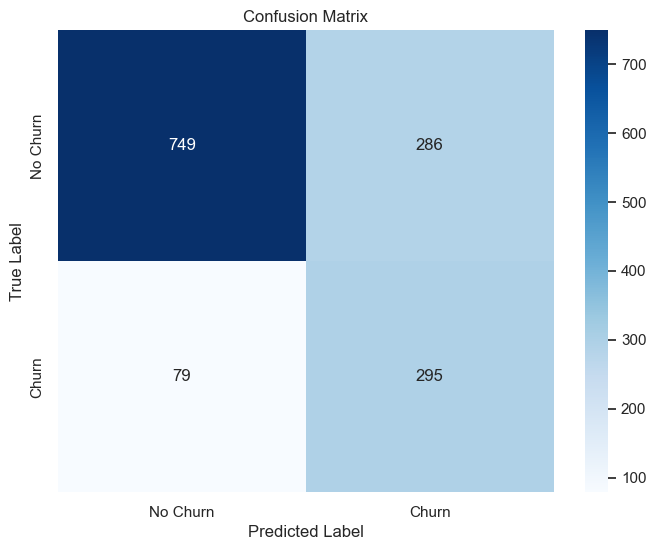

In [71]:
y_pred = model.predict(X_test_processed)
cm = confusion_matrix(y_test_processed, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

<h4 style="text-decoration:underline">6.3. Learning Curve (Overfitting Analysis)</h4>

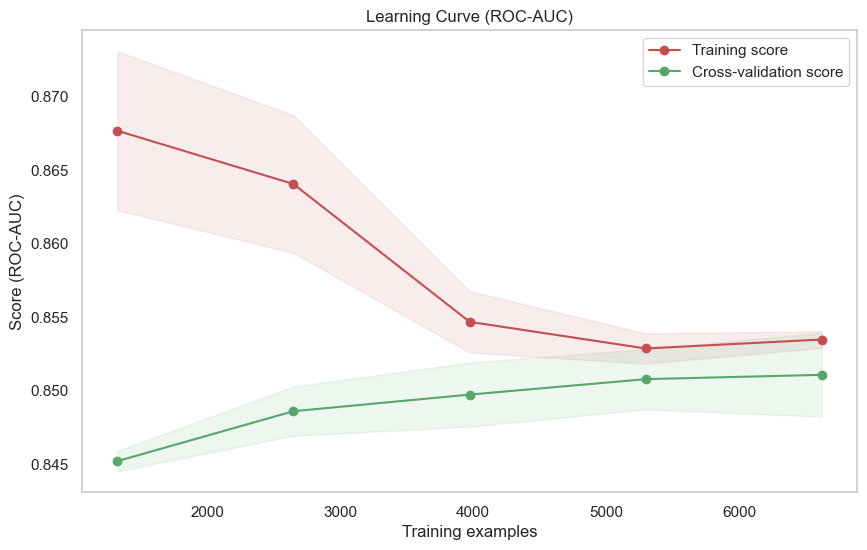

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.2, 1.0, 5)): # <--- CHANGED HERE
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score (ROC-AUC)")
    
    # Check for error_score to handle potential remaining crashes gracefully
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, 
        scoring='roc_auc', error_score='raise') # You can change 'raise' to np.nan to ignore failures
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

plot_learning_curve(model, "Learning Curve (ROC-AUC)", X_train_processed, y_train_processed, cv=cv_strategy)
plt.show()

<h4 style="text-decoration:underline">7. Feature Importance</h4>

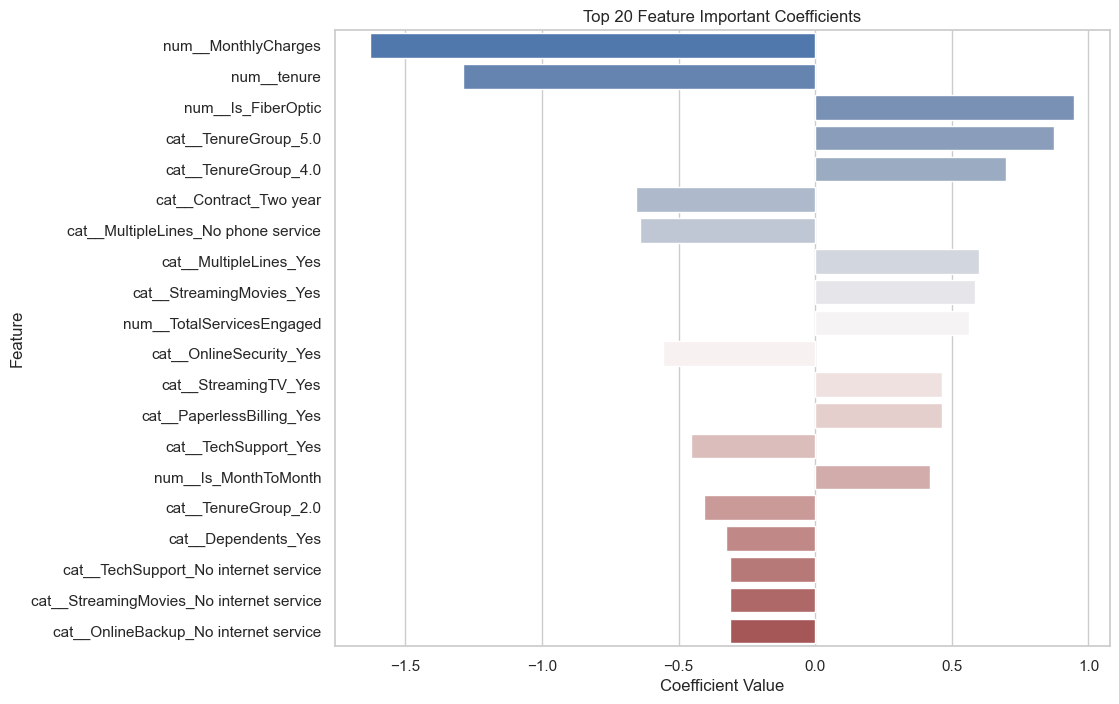

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

feature_names = X_train_processed.columns

if hasattr(model, 'coef_'):
    # Logistic Regression
    importances = model.coef_[0]
    feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feat_imp['AbsImportance'] = feat_imp['Importance'].abs()
    feat_imp = feat_imp.sort_values(by='AbsImportance', ascending=False).head(20)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='vlag', hue='Feature', legend=False)
    plt.title('Top 20 Feature Important Coefficients')
    plt.xlabel('Coefficient Value')
    plt.show()
    
elif hasattr(model, 'feature_importances_'):
    # Tree models (Random Forest, XGBoost, etc.)
    importances = model.feature_importances_
    feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feat_imp = feat_imp.sort_values(by='Importance', ascending=False).head(20)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis', hue='Feature', legend=False)
    plt.title('Top 20 Feature Importances')
    plt.show()